In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [2]:
train_dir='train/'
test_dir = 'test/'
emotions = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [3]:
train_counts = []
for emotion in emotions:
    train_counts.append(len(os.listdir(train_dir + emotion)))
print("Training set:")
for i in range(len(emotions)):
    print(emotions[i] + ": " + str(train_counts[i]))

test_counts = []
for emotion in emotions:
    test_counts.append(len(os.listdir(test_dir + emotion)))
print("\nTest set:")
for i in range(len(emotions)):
    print(emotions[i] + ": " + str(test_counts[i]))

Training set:
angry: 3995
disgusted: 436
fearful: 4097
happy: 7215
neutral: 4965
sad: 4830
surprised: 3171

Test set:
angry: 958
disgusted: 111
fearful: 1024
happy: 1774
neutral: 1233
sad: 1247
surprised: 831


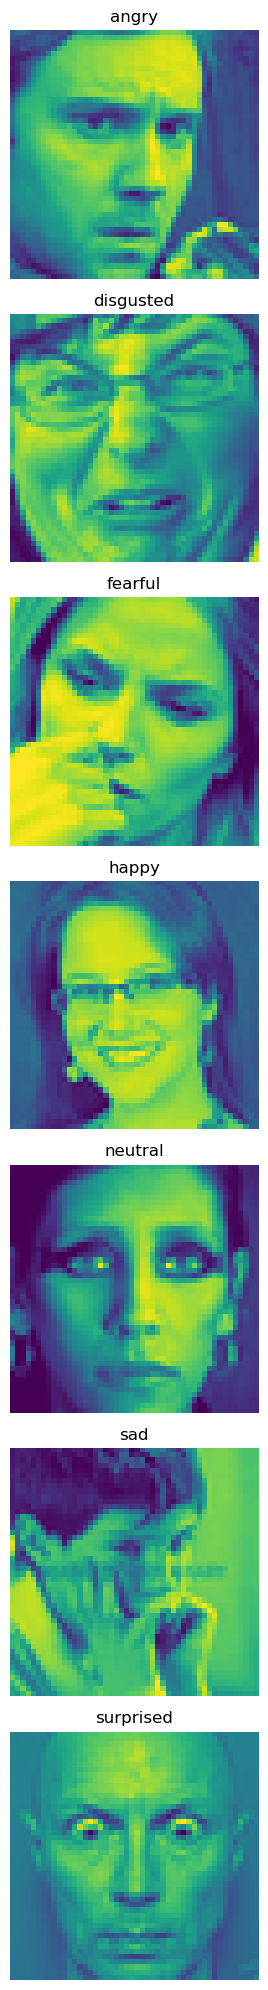

In [4]:
fig, ax = plt.subplots(nrows=len(emotions), ncols=1, figsize=(5,20))


for i, emotion in enumerate(emotions):

    image_path = f"{train_dir}/{emotion}/" + os.listdir(f"{train_dir}/{emotion}")[0]

    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].set_title(emotion)
    ax[i].axis('off')


plt.tight_layout()
plt.show()

In [5]:
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=True, subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=True, subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


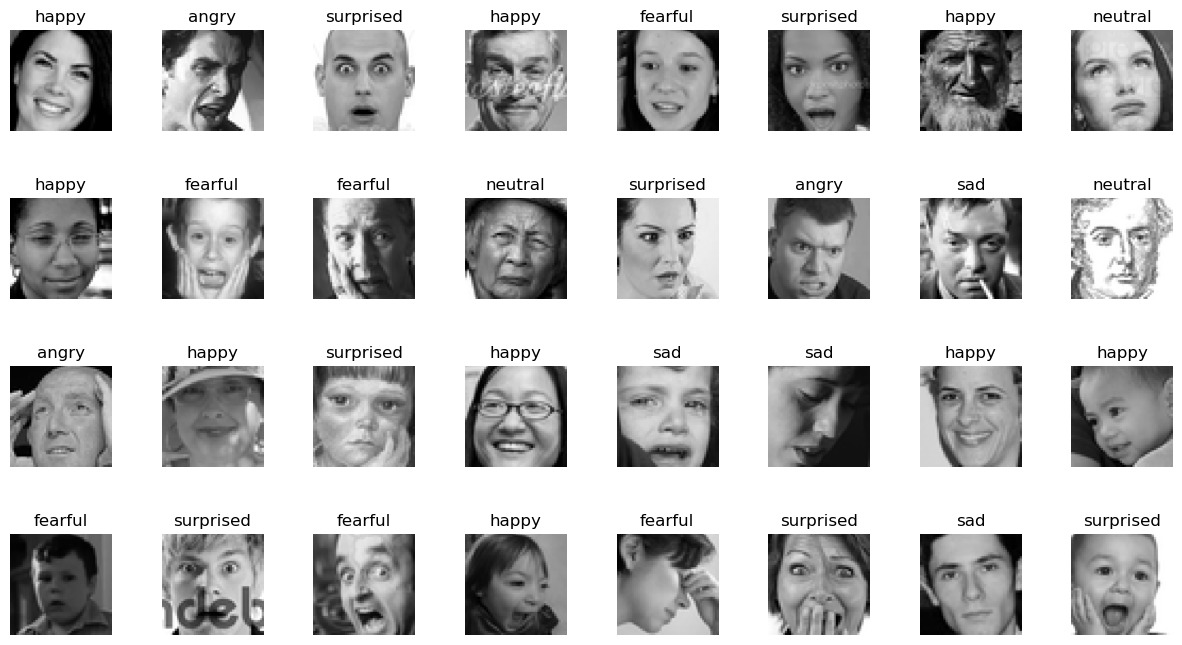

In [6]:
x_batch, y_batch = next(train_generator)


emotion_labels = list(train_generator.class_indices.keys())


fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.ravel()

for i in np.arange(0, 4*8):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    emotion_idx = np.argmax(y_batch[i])
    axes[i].set_title(emotion_labels[emotion_idx])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [7]:
num_classes = len(emotions)

In [8]:
train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_generator[0][0],
    train_generator[0][1],
    test_size=0.2,
    random_state=13
)

In [9]:
train_images = train_images.astype('float32')
validation_images = validation_images.astype('float32')
train_labels = to_categorical(train_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)

In [10]:
print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Images Shape: {validation_images.shape}")
print(f"Validation Labels Shape: {validation_labels.shape}")

Training Images Shape: (25, 224, 224, 3)
Training Labels Shape: (25, 7, 7)
Validation Images Shape: (7, 224, 224, 3)
Validation Labels Shape: (7, 7, 7)


In [11]:
test_images = test_generator[0][0].astype('float32')
test_labels = to_categorical(test_generator[0][1], num_classes)
print(f"Testing Images Shape: {test_images.shape}")
print(f"Testing Labels Shape: {test_labels.shape}")

Testing Images Shape: (32, 224, 224, 3)
Testing Labels Shape: (32, 7, 7)


In [12]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [13]:
for layer in vgg16.layers:
    layer.trainable = False

In [14]:
x = Flatten()(vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [15]:
model_1 = Model(vgg16.input, x)

In [16]:
optimizer = Adam(learning_rate=1e-4)
model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)



718/718 [==============================] - 2210s 3s/step - loss: 1.4805 - accuracy: 0.4407 - val_loss: 1.3083 - val_accuracy: 0.5118


In [18]:
base_model_2 = VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

In [19]:
for layer in base_model_2.layers[:-10]:
    layer.trainable = False

In [20]:
x = Flatten()(base_model_2.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [21]:
model_2 = Model(inputs=base_model_2.input, outputs=x)

In [22]:
optimizer = Adam(learning_rate=1e-4)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [23]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stop]
)

718/718 [==============================] - 33781s 47s/step - loss: 1.4942 - accuracy: 0.4056 - val_loss: 1.2592 - val_accuracy: 0.5181


In [24]:
vgg16_3 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [25]:
for layer in vgg16_3.layers[:-4]:
    layer.trainable = False

In [26]:
x = Flatten()(vgg16_3.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Add another dropout regularization
x = Dense(num_classes, activation='softmax')(x)

In [27]:
model_3 = Model(inputs=vgg16_3.input, outputs=x)

In [28]:
optimizer = Adam(learning_rate=1e-4)
model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [29]:
early_stop = EarlyStopping(patience=4, restore_best_weights=True)
history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

718/718 [==============================] - 2520s 4s/step - loss: 1.3772 - accuracy: 0.4636 - val_loss: 1.2086 - val_accuracy: 0.5443


In [30]:
accuracy_model_1 = history_1.history['val_accuracy']
accuracy_model_2 = history_2.history['val_accuracy']
accuracy_model_3 = history_3.history['val_accuracy']

225/225 [==============================] - 523s 2s/step - loss: 1.1997 - accuracy: 0.5355


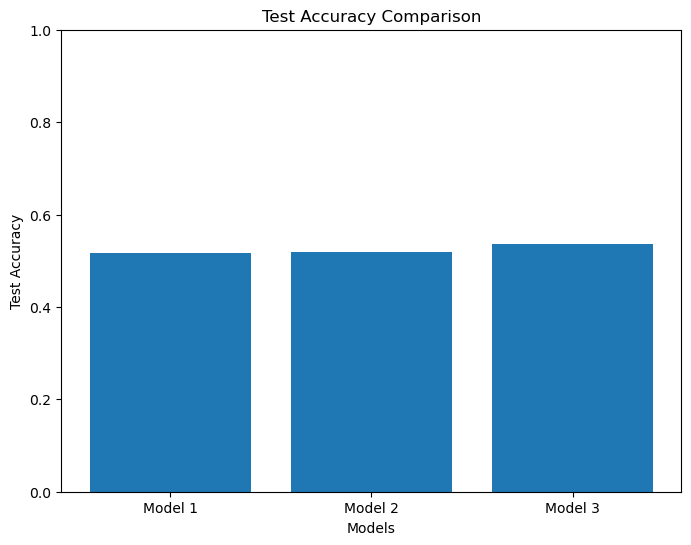

In [32]:
test_loss1, test_accuracy1 = model_1.evaluate(test_generator)


test_loss2, test_accuracy2 = model_2.evaluate(test_generator)


test_loss3, test_accuracy3 = model_3.evaluate(test_generator)


models = ['Model 1', 'Model 2', 'Model 3']
test_accuracies = [test_accuracy1, test_accuracy2, test_accuracy3]

plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies)
plt.title('Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])
plt.show()

In [36]:
model1_predictions = model_1.predict(test_generator)
model1_predicted_labels = np.argmax(model1_predictions, axis=1)


model2_predictions = model_2.predict(test_generator)
model2_predicted_labels = np.argmax(model2_predictions, axis=1)


model3_predictions = model_3.predict(test_generator)
model3_predicted_labels = np.argmax(model3_predictions, axis=1)

225/225 [==============================] - 523s 2s/step


In [37]:
from sklearn.metrics import classification_report


model1_metrics = classification_report(test_generator.classes, model1_predicted_labels, target_names=emotions, zero_division=1)


model2_metrics = classification_report(test_generator.classes, model2_predicted_labels, target_names=emotions, zero_division=1)


model3_metrics = classification_report(test_generator.classes, model3_predicted_labels, target_names=emotions, zero_division=1)



print("Model 1 Metrics:")
print(model1_metrics)

print("Model 2 Metrics:")
print(model2_metrics)

print("Model 3 Metrics:")
print(model3_metrics)

Model 1 Metrics:
              precision    recall  f1-score   support

       angry       0.48      0.32      0.38       958
   disgusted       0.77      0.09      0.16       111
     fearful       0.37      0.29      0.32      1024
       happy       0.73      0.72      0.73      1774
     neutral       0.49      0.46      0.48      1233
         sad       0.35      0.61      0.45      1247
   surprised       0.71      0.58      0.64       831

    accuracy                           0.52      7178
   macro avg       0.56      0.44      0.45      7178
weighted avg       0.54      0.52      0.51      7178

Model 2 Metrics:
              precision    recall  f1-score   support

       angry       0.34      0.49      0.40       958
   disgusted       1.00      0.00      0.00       111
     fearful       0.44      0.08      0.14      1024
       happy       0.74      0.84      0.79      1774
     neutral       0.42      0.62      0.50      1233
         sad       0.38      0.31      0.34 

1/1 [==============================] - 2s 2s/step


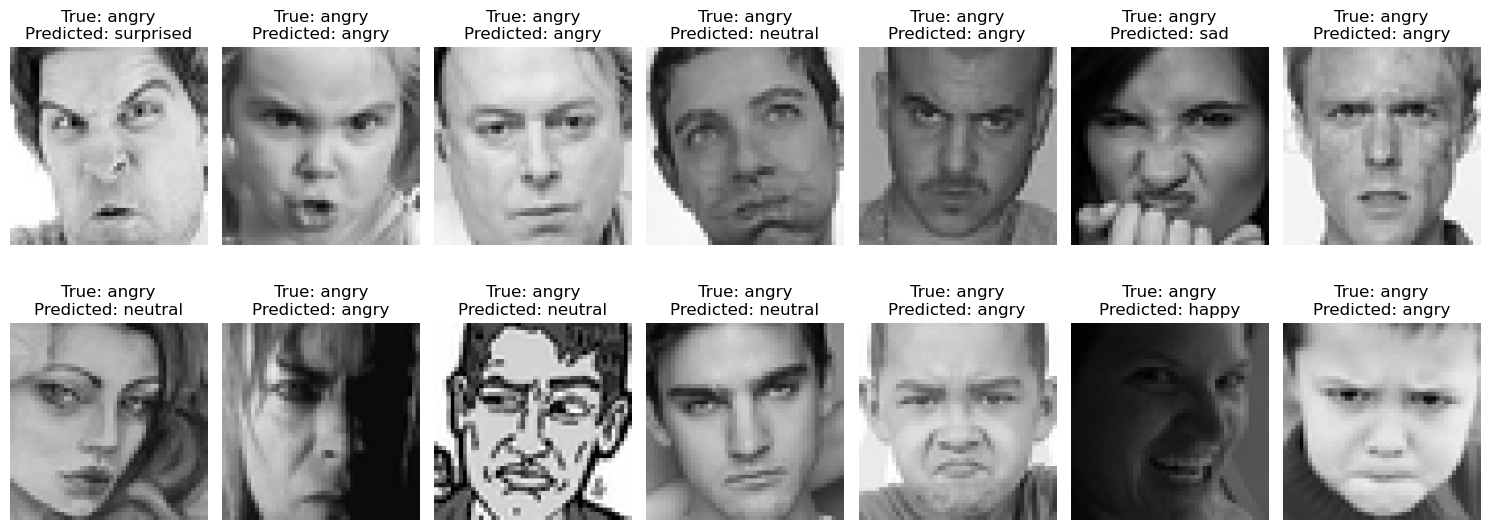

In [38]:
import matplotlib.pyplot as plt
import numpy as np


test_images = test_generator[0][0]
test_labels = test_generator[0][1]
predicted_labels = model_2.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


num_images = 14
random_indices = np.random.choice(len(test_images), size=num_images, replace=False)


fig, axes = plt.subplots(2, 7, figsize=(15, 6))

for i, index in enumerate(random_indices):
    img = test_images[index]
    label = class_labels[np.argmax(test_labels[index])]
    predicted_label = class_labels[predicted_classes[index]]

    row = i // 7
    col = i % 7

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'True: {label}\nPredicted: {predicted_label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()